# Skin Cancer Classification and Segmentation using a modified Unet

In [1]:
cd /content/drive/My Drive/skin-lesion-identification

/content/drive/My Drive/skin-lesion-identification


# Data Preprocessing

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [3]:

#input images directory
input_dir = "images/images/"

#segmentation images directory
target_dir = "segmentation/segmentation/"
img_size = (224, 224)
classes=7
batch_size = 32


In [4]:
metadata = pd.read_csv('HAM10000_metadata.csv')
data = metadata.copy(deep=True)
label_encoder = LabelEncoder()
label_encoder.fit(data['dx'])
data['label'] = label_encoder.transform(data['dx'])
data = data.sort_values('image_id')
data

lesion_id      image_id   dx  ...     sex     localization label
4349  HAM_0000550  ISIC_0024306   nv  ...    male            trunk     5
4263  HAM_0003577  ISIC_0024307   nv  ...    male  lower extremity     5
4217  HAM_0001477  ISIC_0024308   nv  ...  female            trunk     5
3587  HAM_0000484  ISIC_0024309   nv  ...    male            trunk     5
1451  HAM_0003350  ISIC_0024310  mel  ...    male            chest     4
...           ...           ...  ...  ...     ...              ...   ...
1721  HAM_0004304  ISIC_0034316  mel  ...    male  upper extremity     4
1888  HAM_0006376  ISIC_0034317  mel  ...  female  lower extremity     4
121   HAM_0000344  ISIC_0034318  bkl  ...    male            trunk     2
7440  HAM_0000747  ISIC_0034319   nv  ...    male            trunk     5
7363  HAM_0002244  ISIC_0034320   nv  ...  female            chest     5

[10015 rows x 8 columns]

In [5]:
labels = data['label'].to_numpy(dtype=int)
print('Number of samples in each class:')
print(data['label'].value_counts())
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(labels), labels)
class_weights = dict(enumerate(weights))
print('class weights to overcome class imbalance:')
print(class_weights)

Number of samples in each class:
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
class weights to overcome class imbalance:
{0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}


## stratified train validation split of dataset
to overcome class imbalance

In order to have the same distribution of class in the train and validation set, we split the dataset with stratification. The original 10015 image dataset is split into a validation set with 992 images (nearly 1% of the total dataset) and a training set with the rest of the image. To add to the complexity, some of the images in the original dataset have been added more than one time with different augmentations. This can be found by looking at the lesion_id of each image. In order to avoid those images being present in the validation set, we chose only images that had one lesion_id in the dataset. So all 992 images in the validation set were choosen such that there is no other augmented copy of the same image in the training set.


In [6]:
#Here 5514 is the number of samples with only one lesion_id 
#i.e. no augmented copies of the image is present in the dataset
val_labels_stratify = np.zeros(5514, dtype=int)

#Array containing the number of samples that each class should contain 
#in order to have same distribution in the original dataset
temp = np.array(data['label'].value_counts(sort = False)/data['label'].value_counts().sum()*5514).astype(np.int)

x = np.zeros_like(temp)
for i in range(len(temp)):
    for j in range(i+1):
        x[i] +=temp[j]

lower_limit = 0
for i in range(len(x)):
    val_labels_stratify[lower_limit:x[i]] = int(i)
    lower_limit = x[i]

In [7]:
#number of samples each label should contain
Counter(val_labels_stratify)

Counter({0: 183, 1: 282, 2: 605, 3: 63, 4: 612, 5: 3691, 6: 78})

In [8]:
#getting lesion_id with only one copy for the validation set
val_df = data.groupby('lesion_id').filter(lambda x: len(x)==1).drop_duplicates(subset='lesion_id')
val_image_id = val_df['image_id']
val_labels_id = val_df['label']

#getting lesion_id with more than one copies for the training set
train_df = data.groupby('lesion_id').filter(lambda x: len(x)>1)#.drop_duplicates(subset='lesion_id')
train_image_id = train_df['image_id']
train_labels_id = train_df['label']

#splitting of data which has only one copy of lesion_id
X_train, X_val, y_train, y_val = train_test_split(val_image_id, val_labels_id, test_size = 992,
                                                  random_state=1, stratify=val_labels_stratify )

#concating lesion_id with one copy in the X_train a lesion_id with more than one copy
X_train = pd.concat([X_train, train_image_id])
y_train = pd.concat([y_train, train_labels_id])

#defining image path, segmentation path and labels of the training set
train_input_img_paths = 'images/images/' + X_train.values + '.jpg'
train_target_img_paths = 'segmentation/segmentation/' + X_train.values + '_segmentation.png'
train_labels = y_train.values

#defining image path, segmentation path and labels of the validation set
val_input_img_paths = 'images/images/' + X_val.values + '.jpg'
val_target_img_paths = 'segmentation/segmentation/' + X_val.values + '_segmentation.png'
val_labels = y_val.values

In [9]:
#printing training image path, segmentation path and corresponding labels
print('Number of samples in the training set:{}'.format(len(train_labels)))
for input_path, target_path, label in zip(train_input_img_paths[:10], train_target_img_paths[:10], train_labels[:10]):
    print(input_path, "|", target_path, "|", label)

Number of samples in the training set:9023
images/images/ISIC_0027981.jpg | segmentation/segmentation/ISIC_0027981_segmentation.png | 5
images/images/ISIC_0028236.jpg | segmentation/segmentation/ISIC_0028236_segmentation.png | 2
images/images/ISIC_0028854.jpg | segmentation/segmentation/ISIC_0028854_segmentation.png | 0
images/images/ISIC_0029574.jpg | segmentation/segmentation/ISIC_0029574_segmentation.png | 4
images/images/ISIC_0032093.jpg | segmentation/segmentation/ISIC_0032093_segmentation.png | 5
images/images/ISIC_0031306.jpg | segmentation/segmentation/ISIC_0031306_segmentation.png | 5
images/images/ISIC_0027296.jpg | segmentation/segmentation/ISIC_0027296_segmentation.png | 5
images/images/ISIC_0030100.jpg | segmentation/segmentation/ISIC_0030100_segmentation.png | 5
images/images/ISIC_0026682.jpg | segmentation/segmentation/ISIC_0026682_segmentation.png | 5
images/images/ISIC_0027218.jpg | segmentation/segmentation/ISIC_0027218_segmentation.png | 2


In [10]:
#printing validation image path, segmentation path and corresponding labels
print('Number of samples in the validation set:{}'.format(len(val_labels)))
for input_path, target_path, label in zip(val_input_img_paths[:10], val_target_img_paths[:10], val_labels[:10]):
    print(input_path, "|", target_path, "|", label)

Number of samples in the validation set:992
images/images/ISIC_0028090.jpg | segmentation/segmentation/ISIC_0028090_segmentation.png | 5
images/images/ISIC_0026130.jpg | segmentation/segmentation/ISIC_0026130_segmentation.png | 5
images/images/ISIC_0032054.jpg | segmentation/segmentation/ISIC_0032054_segmentation.png | 5
images/images/ISIC_0024371.jpg | segmentation/segmentation/ISIC_0024371_segmentation.png | 2
images/images/ISIC_0028189.jpg | segmentation/segmentation/ISIC_0028189_segmentation.png | 5
images/images/ISIC_0025883.jpg | segmentation/segmentation/ISIC_0025883_segmentation.png | 2
images/images/ISIC_0030612.jpg | segmentation/segmentation/ISIC_0030612_segmentation.png | 5
images/images/ISIC_0024389.jpg | segmentation/segmentation/ISIC_0024389_segmentation.png | 5
images/images/ISIC_0031341.jpg | segmentation/segmentation/ISIC_0031341_segmentation.png | 5
images/images/ISIC_0026867.jpg | segmentation/segmentation/ISIC_0026867_segmentation.png | 2


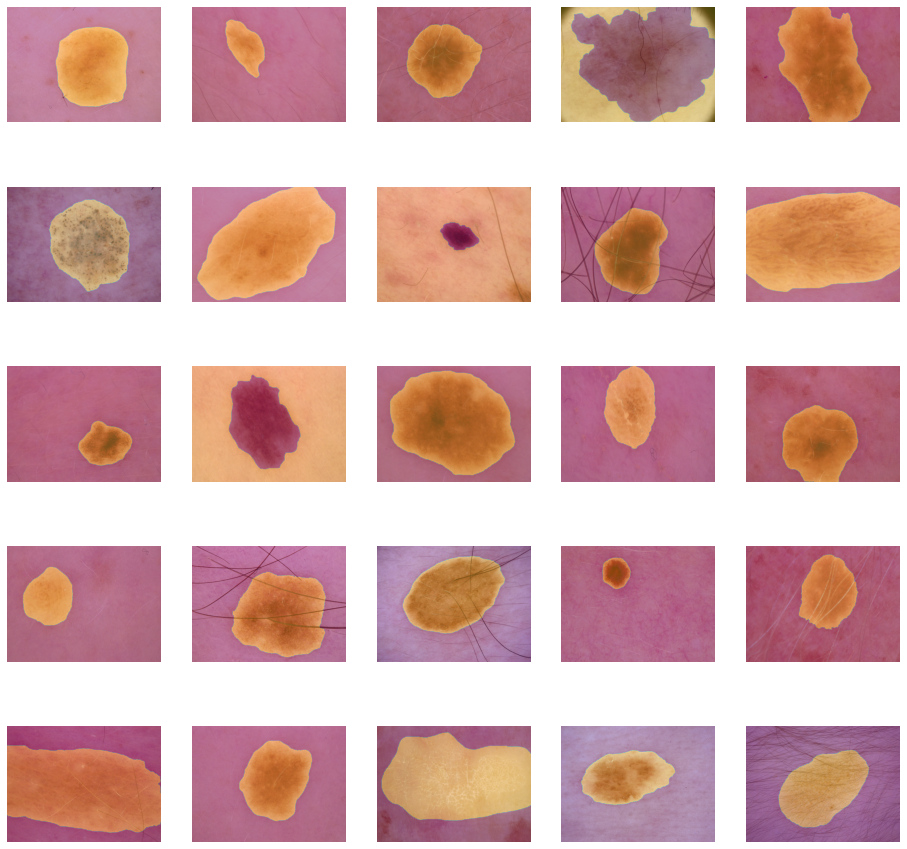

In [11]:
fig = plt.figure()
fig.set_size_inches(16,16)
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('Off')
    plt.imshow(np.array(Image.open(val_input_img_paths[i])))
    plt.imshow(np.array(Image.open(val_target_img_paths[i])), alpha=0.3)   


In [12]:
def invert_segmentation(image_data):
    """Inverts the segmentation data of the image if the skin lesion is 0 and the background is 1."""
    if image_data[0][0]>0:
        inverted_image_data = np.logical_not(image_data)
        inverted_image_data = inverted_image_data.astype(int)
        return inverted_image_data
    else :
        return image_data 

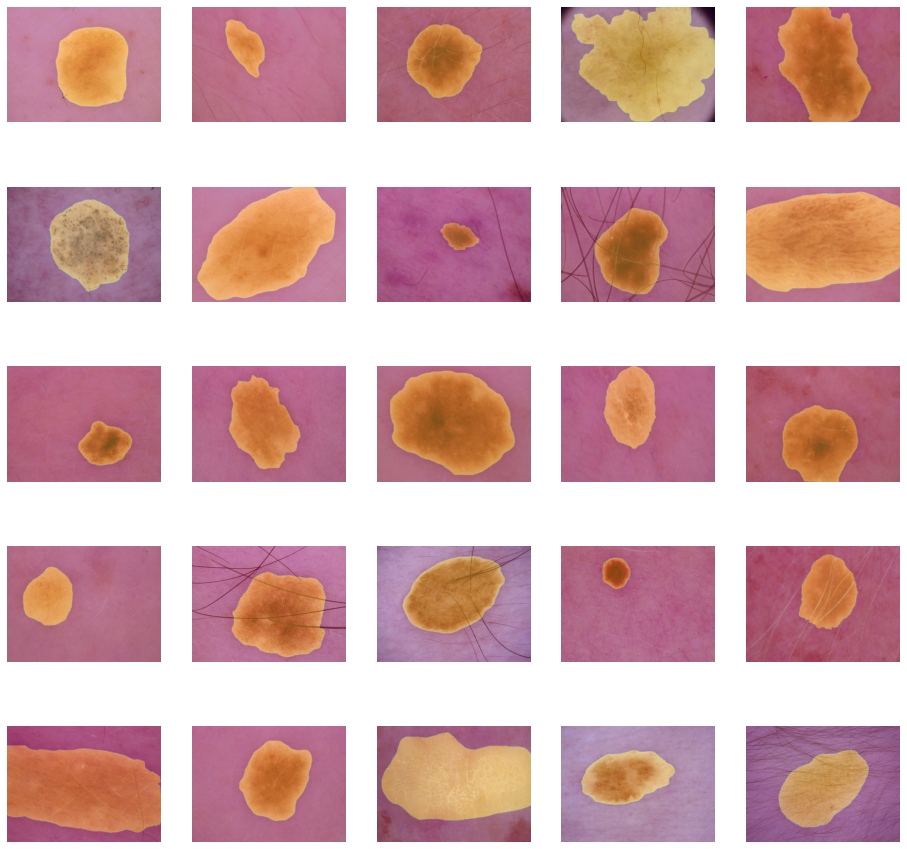

In [13]:
fig = plt.figure()
fig.set_size_inches(16,16)
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('Off')
    plt.imshow(np.array(Image.open(val_input_img_paths[i])))
    plt.imshow(invert_segmentation(np.array(Image.open(val_target_img_paths[i]))), alpha=0.3)   

# Model Architecture

In [14]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dropout, Conv2D, UpSampling2D, BatchNormalization, Activation, Concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import load_img


In [16]:
feature_layers = ('block_13_expand_relu', 'block_6_expand_relu', 'block_3_expand_relu',
                        'block_1_expand_relu')

In [17]:
def Conv2dBN(filters, kernel_size, activation=None, padding='valid', kernel_initializer='glorot_uniform', use_batchnorm=False, name = None):
    """Extension of Conv2D layer with batchnorm"""
    convolution_name, activation_name, batchnorm_name = None, None, None
    block_name = name
    if block_name is not None:
        convolution_name = block_name + '_conv'
        if activation is not None:
            activation_str = activation.__name__ if callable(activation) else str(activation)
            activation_name = block_name + '_' + activation_str
            if use_batchnorm:
                batchnorm_name = block_name + '_bn'

    def encoder(input_tensor):
        x = Conv2D(filters = filters,
                kernel_size=kernel_size,
                padding=padding,
                use_bias=not (use_batchnorm),
                kernel_initializer = kernel_initializer,
                name = convolution_name)(input_tensor)

        if use_batchnorm:
            x = BatchNormalization(name=batchnorm_name)(x)

        if activation:
            x = Activation(activation, name=activation_name)(x)

        return x
    return encoder
               

In [18]:
def Conv3x3BNReLU(filters, use_batchnorm, name=None):
    def wrapper(input_tensor):
        return Conv2dBN(filters, kernel_size=3, 
                        activation='relu',
                        kernel_initializer='he_uniform',
                        padding='same',
                        use_batchnorm=use_batchnorm,
                        name=name)(input_tensor)
                    
    return wrapper

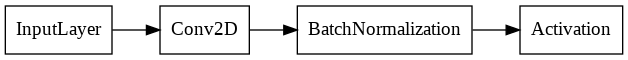

In [19]:
input1 = Input(shape=(28, 28, 44))
out = Conv3x3BNReLU(256, use_batchnorm=True)(input1)
mm = Model(input1, out)
plot_model(mm, show_layer_names=False, rankdir='LR')

In [20]:
def DecoderUpsamplingX2Block(filters, stage, use_batchnorm=False):
    up_name = 'decoder_stage{}_upsampling'.format(stage)
    conv1_name = 'decoder_stage{}a'.format(stage)
    conv2_name = 'decoder_stage{}b'.format(stage)
    concat_name = 'decoder_stage{}_concat'.format(stage)

    #concat_axis = 3

    def wrapper(input_tensor, skip=None):
        x = UpSampling2D(size=2, name=up_name)(input_tensor)

        if skip is not None:
            x = Concatenate(axis=-1, name=concat_name)([x, skip])

        x = Conv3x3BNReLU(filters, use_batchnorm, name=conv1_name)(x)
        x = Conv3x3BNReLU(filters, use_batchnorm, name=conv2_name)(x)
        return x
    return wrapper

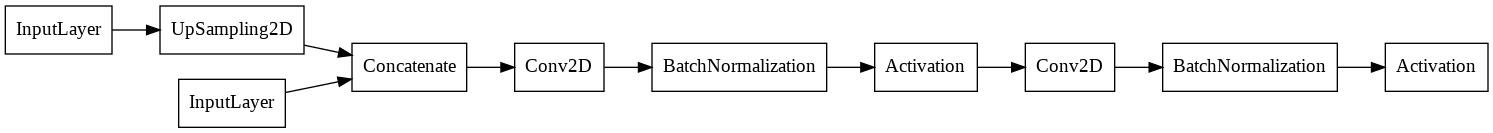

In [21]:
input1 = Input(shape=(28, 28, 44))
input2 = Input(shape=(56, 56, 44))
out = DecoderUpsamplingX2Block(256, 1, use_batchnorm=True)(input1, input2)
mm = Model([input1,input2], out)
plot_model(mm, show_layer_names=False, rankdir='LR')

In [22]:
def Unet(skip_connection_layers, input_shape=(224, 224, 3), encoder_freeze=False, decoder_filters=(256, 128,64, 32, 16),
         n_upsample_blocks=5, classes=1, activation='sigmoid', use_batchnorm=True):
    """
    Defining fully convolutional Unet neural network for image semantic segmentation
    The encoder backbone of the Unet used here is MobilenetV2.
    The decoder block layer structure is :
        ``UpSampling2D`` -> ``Skip connection`` -> ``Conv2D`` -> ``BatchNorm`` -> ``ReLU Activation`` -> ``Conv2D``
        -> ``BatchNorm`` -> ``ReLU Activation`` 
    
    Args : 
        skip_connection_layers: A list of MobileNetV2 layer names which will be concatenated with the corresponding
            decoder block.
        input_shape: Shape of input image in (height, width, number of channels) format.
        encoder_freeze: if ``True`` set all layers of the encoder as non-trainable
        decoder_filters: list of numbers of ``Conv2D`` layer filters in decoder blocks
        classes: Number of classes for output [output_shape = (height, width, classes)]
        activation: activation to be used in the last layer 
        use_batchnorm: if ``True`` , ``BatchNormalization`` layer between ``Conv2D`` and ``Activation`` is used.
    
    Returns:
        ``tensorflow.keras.models.Model``: **Unet**

    Reference:
        https://arxiv.org/pdf/1505.04597



    """
    backbone = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    input_ = backbone.input
    x = backbone.output

    skips = ([backbone.get_layer(name=i).output for i in skip_connection_layers])

    #building decoder blocks
    for i in range(len(decoder_filters)):
        if i < len(skips):
            skip = skips[i]
        else :
            skip = None    
        x = DecoderUpsamplingX2Block(decoder_filters[i], stage=i, use_batchnorm=use_batchnorm)(x, skip)

    x = Conv2D(filters=classes, kernel_size=(3,3),
               padding='same', name='final_conv')(x)
    x = Activation(activation, name=activation)(x)

    if encoder_freeze:
        backbone.trainable = False

    model = Model(input_, x)

    return model

In [23]:
def Unet_classification(Unet_model, num_class, encoder_freeze):
    unet_model = Unet_model(skip_connection_layers=feature_layers, encoder_freeze=encoder_freeze)
    x = unet_model.input
    out = unet_model.get_layer(name='out_relu').output
    out = GlobalAveragePooling2D()(out)
    out = Dense(128, activation = 'relu')(out)
    out = Dropout(0.4)(out)
    out = Dense(128, activation = 'relu')(out)
    out = Dense(num_class, activation='softmax', name='classification')(out)
    model = Model(x, [unet_model.output, out])

    return model

In [24]:
model = Unet_classification(Unet, 7, encoder_freeze=True)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

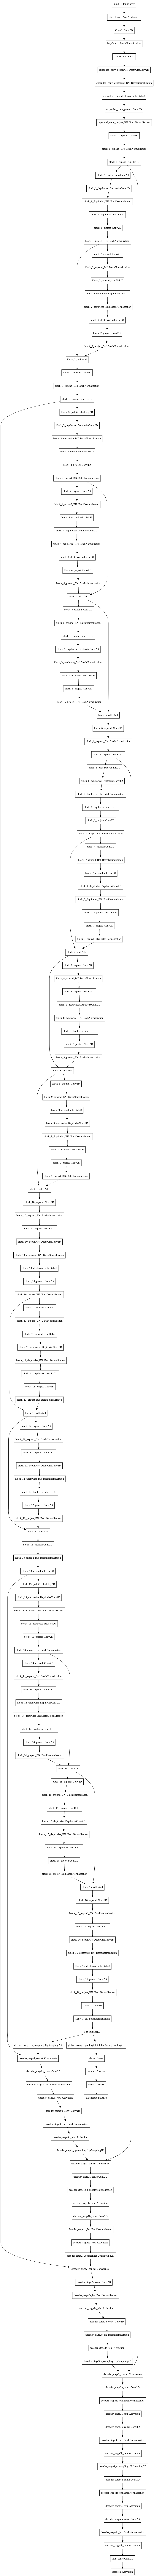

In [25]:
plot_model(model)

# Compiling and fitting the model

In [26]:
class HamDatasetClassification(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, classes, input_img_paths, target_img_paths, labels):
        self.batch_size = batch_size
        self.img_size = img_size
        self.classes = classes
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.labels = labels

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        batch_labels = self.labels[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = preprocess_input(np.array(img))

        y = np.zeros((self.batch_size,) + self.img_size + (1,))
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img_data = np.expand_dims(img, axis = 2)
            img_data = invert_segmentation(np.array(img_data))
            y[j] = img_data/255
        
        label = to_categorical(batch_labels, self.classes)
        return x, [y,label]

In [27]:
# Instantiate data Sequences for each split
train_gen = HamDatasetClassification(batch_size, img_size, classes, train_input_img_paths, train_target_img_paths, train_labels)
val_gen = HamDatasetClassification(batch_size, img_size, classes, val_input_img_paths, val_target_img_paths, val_labels)

In [28]:
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype = tf.float32)
    def loss(y_true, y_pred):
        l = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        l = l*weights[tf.math.argmax(y_true[0])]
        return l
    
    return loss

loss = weighted_categorical_crossentropy(weights)

In [29]:
model.compile(optimizer="adam", loss=["binary_crossentropy", loss], metrics=['accuracy'], loss_weights=[5,1])

In [25]:
model.fit(train_gen, epochs=1, validation_data=val_gen) 

281/281 [==============================] - 10094s 36s/step - loss: 2.1041 - sigmoid_loss: 0.1717 - classification_loss: 1.2459 - sigmoid_accuracy: 0.9340 - classification_accuracy: 0.6544 - val_loss: 0.9559 - val_sigmoid_loss: 0.1355 - val_classification_loss: 0.2782 - val_sigmoid_accuracy: 0.9485 - val_classification_accuracy: 0.8135


In [ ]:
mc = ModelCheckpoint('best_model.h5', monitor='val_classification_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=[mc]) 

In [31]:
model = load_model('best_model.h5', custom_objects={'loss':loss})

In [36]:
performance = model.evaluate(val_gen)
print('Total loss               : {}'.format(performance[0]))
print('segmentation loss        : {}'.format(performance[1]))
print('classification loss      : {}'.format(performance[2]))
print('segmentation accuracy    : {}'.format(performance[3]))
print('classification_accuracy  : {}'.format(performance[4]))

31/31 [==============================] - 13s 432ms/step - loss: 0.4190 - sigmoid_loss: 0.0533 - classification_loss: 0.1526 - sigmoid_accuracy: 0.9857 - classification_accuracy: 0.9062
Total loss               : 0.4190433621406555
segmentation loss        : 0.05329642444849014
classification loss      : 0.1525612622499466
segmentation accuracy    : 0.985673189163208
classification_accuracy  : 0.90625


# Evaluating Performance

In [37]:
def predict_output(model, input_data, threshold = 0.5):
    """Predicts the segmentation and class of the input image."""
    if isinstance(input_data, str):
        data = load_img(input_data, target_size=(224,224))
        data = np.array(data)
    if isinstance(input_data, np.ndarray):
        data = input_data
    
    label = ['akiec','bcc','bkl','df','mel','nv','vasc'] 

    height, width, channel = data.shape
    if height == 224 and width == 224 and channel == 3:
        data = np.expand_dims(data, axis = 0)
        preprocessed_data = preprocess_input(data)
        prediction = model.predict(preprocessed_data)
        segmentation = prediction[0][0,:,:,0]
        predicted_class = np.argmax(prediction[1][0])
        predicted_score = max(prediction[1][0])

        result = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                if segmentation[i][j] > threshold:
                    result[i][j] = 1
                else : 
                    result[i][j] = 0

        print('Predicted Class : {}'.format(predicted_class))
        print('Predicted Label : {}'.format(label[predicted_class]))
        print('Predicted score : {}'.format(predicted_score))
        fig = plt.figure()
        fig.set_size_inches((12, 5))
        plt.subplot(1,3,1)
        plt.title('Input Image')
        plt.imshow(data[0])
        plt.axis('Off')
        plt.subplot(1,3,2)
        plt.title('Predicted Segmentation')
        plt.imshow(result)
        plt.axis('Off')
        plt.subplot(1,3,3)
        plt.title('Overlayed Segmentation')
        plt.imshow(data[0])
        plt.imshow(result, alpha=0.4)
        plt.axis('Off')
        plt.show()
    else :
        print('Input Image shape not valid. Should be (224, 224, 3) but got {}'.format(data.shape))

Predicted Class : 5
Predicted Label : nv
Predicted score : 0.9999933242797852


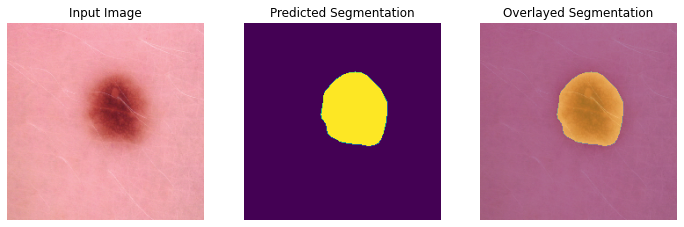

Predicted Class : 5
Predicted Label : nv
Predicted score : 0.9999324083328247


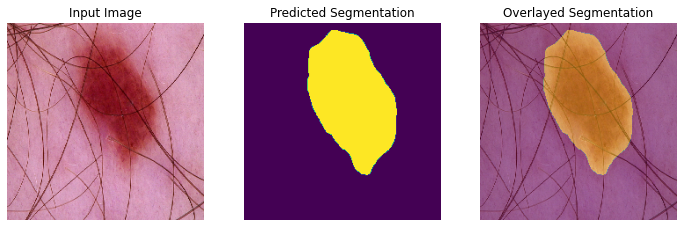

Predicted Class : 5
Predicted Label : nv
Predicted score : 0.9705167412757874


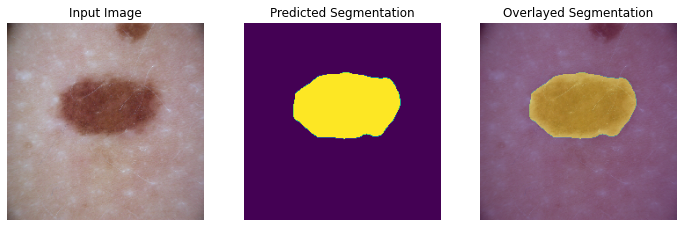

Predicted Class : 1
Predicted Label : bcc
Predicted score : 0.7348884344100952


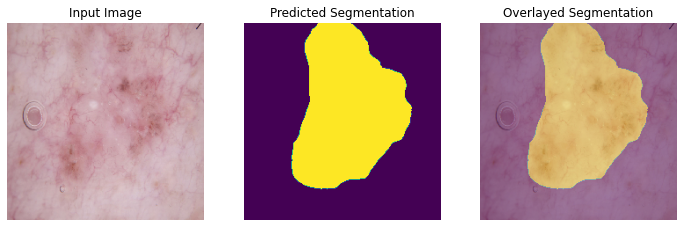

Predicted Class : 4
Predicted Label : mel
Predicted score : 0.4512506127357483


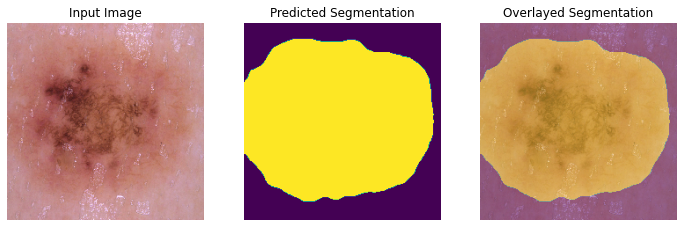

In [40]:
for _ in range(5):
    index = np.random.randint(0, 992)
    predict_output(model, val_input_img_paths[index])

In [41]:
_,validation_prediction = model.predict(val_gen)

In [42]:
validation_prediction.shape

(992, 7)

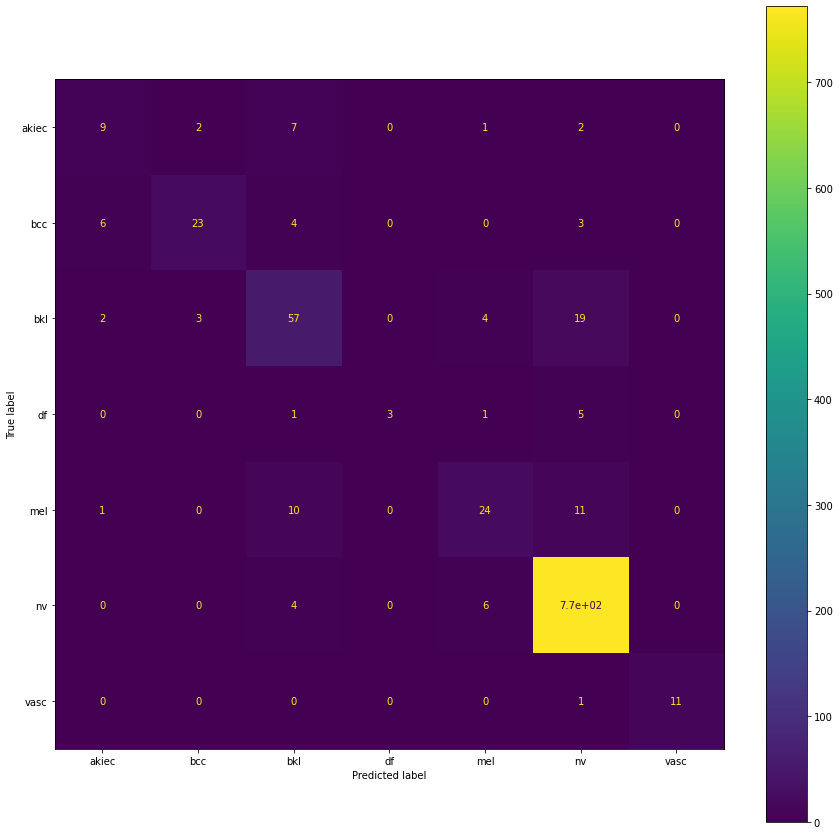

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(val_labels, np.argmax(validation_prediction, axis = -1))
fig, ax = plt.subplots(figsize=(15, 15))
x =  ConfusionMatrixDisplay(cm, display_labels =['akiec','bcc','bkl','df','mel','nv','vasc'] ).plot(ax=ax)
